# POP MOC(sig2) for 0.1-degree
 - Computes MOC(sig2) offline from POP history files using simple xhistogram binning

In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr 
import numpy as np  
import cftime
import dask
from xhistogram.xarray import histogram
import pop_tools
import matplotlib.pyplot as plt
%matplotlib inline

from MOCutils import popmoc

In [2]:
import dask
from dask.distributed import wait
dask.__version__

'2022.11.0'

### Start Dask Cluster

### 1. Read in OGCM history file & MOC template file

In [3]:
def time_set_midmonth(ds, time_name, deep=False):
    """
    Return copy of ds with values of ds[time_name] replaced with mid-month
    values (day=15) rather than end-month values.
    """
    #ds_out = ds.copy(deep)
    year = ds[time_name].dt.year
    month = ds[time_name].dt.month
    year = xr.where(month==1,year-1,year)
    month = xr.where(month==1,12,month-1)
    nmonths = len(month)
    newtime = [cftime.DatetimeNoLeap(year[i], month[i], 15) for i in range(nmonths)]
    ds[time_name] = newtime
    return ds

def preprocessor(ds0):
    keepvars = ['UVEL','VVEL','TEMP','SALT']
    d0 = ds0[keepvars]
    d0 = time_set_midmonth(d0,'time')
    d0 = d0.groupby('time.year').mean('time').rename({'year':'time'})
    return d0

In [4]:
#fdir = '/glade/campaign/cgd/oce/people/whokim/csm/g.e21.GRYF_0304.TL319_t13.003/ocn/hist/'
fdir = '/data3/dxl/'
fin = fdir + 'B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02.pop.h.0313-09.nc'
ds = xr.open_mfdataset(fin,combine='by_coords',
                       preprocess=preprocessor,chunks={'time':1,'nlat':200},
                       coords="minimal",compat="override",data_vars="minimal",
                       parallel=True,)

fgrd = '/data3/dxl/B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02.pop.h.0313-09.nc'
###  fgrd = '/glade/work/whokim/grid/POP.TL319_t13.grid.nc' # 
ds_grid = xr.open_dataset(fgrd)

fmoc = '/home/dxl/POP_MOC-main/moc_template.nc'
ds_moctemp = xr.open_dataset(fmoc)

In [5]:
%%time
dz = ds_grid['dz'].persist() / 100.
kmt = ds_grid['KMT'].fillna(0).persist() 
dzt,dzu = popmoc.tx0p1v3_dztdzu(dz,kmt)

CPU times: user 11.8 s, sys: 18.7 s, total: 30.5 s
Wall time: 30.9 s


### 2. Compute sigma-2 field from POP model output

In [6]:
# Get model T & S
salt = ds['SALT']
temp = ds['TEMP']
salt = xr.where(salt.values<=0,np.nan,salt)
temp = xr.where(temp.values==-1,np.nan,temp)


In [7]:
temp[0,0,:200,0].values

array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        

In [8]:
%%time
refz = 2000
refdep = xr.full_like(ds['z_t'],refz).rename('REFDEP')

# Sigma2 on model TLAT, TLONG
sigma2_T = pop_tools.eos(salt=salt,temp=temp,depth=refdep) - 1000
sigma2_T = sigma2_T.assign_attrs({'long_name':'Sigma referenced to {}m'.format(refz),'units':'kg/m^3'})

CPU times: user 2.67 s, sys: 374 ms, total: 3.04 s
Wall time: 3.04 s


In [9]:
sigma2_T = xr.where(sigma2_T.values<10,np.nan,sigma2_T)
#sigma2_T = sigma2_T.fillna(0)

In [10]:
sigma2_T[0,0,:200,0].values

array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,      

In [11]:
KKK = xr.where(ds_grid['KMT'].values<=0,np.nan,ds_grid['KMT'])

In [12]:
KKK[:200,0].values

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, 24., 27., 27., 30., 31., 32., 32.,
       32., 32., 32., 33., 33., 33., 33., 34., 34., 34., 35., 35., 35.,
       35., 35., 36., 36., 36., 37., 37., 37., 37., 37., 37., 38., 38.,
       38., 38., 38., 38., 38., 38., 38., 39., 39., 39., 39., 39., 39.,
       39., 39., 39., 39., 39., 39., 39., 39., 39., 40., 40., 40., 40.,
       40., 40., 40., 40., 40., 40., 40., 41., 42., 43., 44., 44., 44.,
       45., 45., 45., 45., 45., 46., 47., 49., 50., 51., 51., 50

### 3. Define target sigma-2 vertical grid
- Use a predefined target grid, or create your own!

In [13]:
# Use predefined 86-layer sigma2 grid:
sigma_mid,sigma_edge = popmoc.sigma2_grid_86L()

In [14]:
sigma_mid

<xarray.DataArray (sigma: 86)>
array([28.  , 28.2 , 28.4 , 28.6 , 28.8 , 29.  , 29.2 , 29.4 , 29.6 ,
       29.8 , 30.  , 30.2 , 30.4 , 30.6 , 30.8 , 31.  , 31.2 , 31.4 ,
       31.6 , 31.8 , 32.  , 32.2 , 32.4 , 32.6 , 32.8 , 33.  , 33.2 ,
       33.4 , 33.6 , 33.8 , 34.  , 34.2 , 34.4 , 34.6 , 34.8 , 35.  ,
       35.1 , 35.2 , 35.3 , 35.4 , 35.5 , 35.6 , 35.7 , 35.8 , 35.9 ,
       36.  , 36.05, 36.1 , 36.15, 36.2 , 36.25, 36.3 , 36.35, 36.4 ,
       36.45, 36.5 , 36.55, 36.6 , 36.65, 36.7 , 36.75, 36.8 , 36.85,
       36.9 , 36.95, 37.  , 37.05, 37.1 , 37.15, 37.2 , 37.25, 37.3 ,
       37.35, 37.4 , 37.45, 37.5 , 37.55, 37.6 , 37.65, 37.7 , 37.75,
       37.8 , 37.85, 37.9 , 37.95, 38.  ], dtype=float32)
Coordinates:
  * sigma    (sigma) float32 28.0 28.2 28.4 28.6 28.8 ... 37.85 37.9 37.95 38.0
Attributes:
    long_name:  Sigma2 at middle of layer
    units:      kg/m^3

In [15]:
sigma_edge

<xarray.DataArray (sigma: 87)>
array([ 0.      , 28.1     , 28.3     , 28.5     , 28.7     , 28.9     ,
       29.1     , 29.3     , 29.5     , 29.7     , 29.9     , 30.1     ,
       30.3     , 30.5     , 30.7     , 30.9     , 31.1     , 31.3     ,
       31.5     , 31.7     , 31.9     , 32.1     , 32.300003, 32.5     ,
       32.699997, 32.9     , 33.1     , 33.300003, 33.5     , 33.699997,
       33.9     , 34.1     , 34.300003, 34.5     , 34.699997, 34.9     ,
       35.05    , 35.15    , 35.25    , 35.35    , 35.45    , 35.55    ,
       35.65    , 35.75    , 35.85    , 35.95    , 36.025   , 36.074997,
       36.125   , 36.175003, 36.225   , 36.275   , 36.324997, 36.375   ,
       36.425003, 36.475   , 36.525   , 36.574997, 36.625   , 36.675003,
       36.725   , 36.775   , 36.824997, 36.875   , 36.925003, 36.975   ,
       37.025   , 37.074997, 37.125   , 37.175003, 37.225   , 37.275   ,
       37.324997, 37.375   , 37.425003, 37.475   , 37.525   , 37.574997,
       37.625   , 37.675003, 37.725   , 37.775   , 37.824997, 37.875   ,
       37.925003, 37.975   , 50.      ], dtype=float32)
Coordinates:
  * sigma    (sigma) float32 0.0 28.1 28.3 28.5 28.7 ... 37.88 37.93 37.97 50.0
Attributes:
    long_name:  Sigma2 at edges of layer
    units:      kg/m^3

### 4. Compute Isopycnal Layer Thickness (Can skip if not needed)

In [16]:
%%time
# Here, test histogram by counting cells in each density bin. Vertical sum should be same as KMT.
iso_count = histogram(sigma2_T, bins=[sigma_edge.values],dim=['z_t'],density=False)
iso_count = iso_count.rename({'density_bin':'sigma'}).assign_coords({'sigma':sigma_mid})
NNN = iso_count.sum('sigma').sum('time')
NNN2 = xr.where(NNN.values<=0,np.nan,NNN)
kmtdiff = NNN2 - KKK
print("Max difference from true KMT = {}".format(abs(kmtdiff).max().values))

Max difference from true KMT = 4.0
CPU times: user 2min 3s, sys: 50.3 s, total: 2min 53s
Wall time: 1min 5s


In [17]:
NNN2[:200,0].values

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, 24., 27., 27., 30., 31., 32., 32.,
       32., 32., 32., 33., 33., 33., 33., 34., 34., 34., 35., 35., 35.,
       35., 35., 36., 36., 36., 37., 37., 37., 37., 37., 37., 38., 38.,
       38., 38., 38., 38., 38., 38., 38., 39., 39., 39., 39., 39., 39.,
       39., 39., 39., 39., 39., 39., 39., 39., 39., 40., 40., 40., 40.,
       40., 40., 40., 40., 40., 40., 40., 41., 42., 43., 44., 44., 44.,
       45., 45., 45., 45., 45., 46., 47., 49., 50., 51., 51., 50

In [18]:
kmtdiff[:200,0].values

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

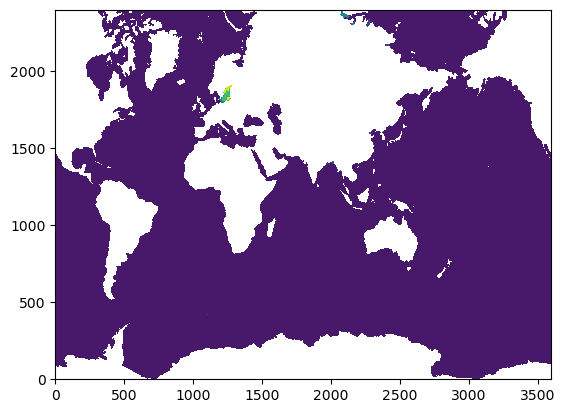

In [19]:
# other regions are good (all = 0), however, the Baltic region have some bad values, I am not sure what is the problem here 
plt.contourf(abs(kmtdiff[:,:]))

In [20]:
HHH = xr.where(ds_grid['HT'].values<=0,np.nan,ds_grid['HT'])

In [21]:
%%time
# Use histogram to compute layer thickness. Vertical sum should be same as HT.
iso_thick = histogram(sigma2_T, bins=[sigma_edge.values], weights=dzt,dim=['z_t'],density=False)
iso_thick = iso_thick.rename({'density_bin':'sigma'}).assign_coords({'sigma':sigma_mid})
iso_thick = iso_thick.rename('iso_thick').assign_attrs({'units':'m','long_name':'Isopycnal Layer Thickness'}).rename({'sigma':'sigma_mid'})
iso_thick = iso_thick.transpose('time','sigma_mid','nlat','nlon')
MMM = iso_thick.sum('sigma_mid').sum('time')
MMM = xr.where(NNN.values<=0,np.nan,MMM)

htdiff = MMM - (HHH/100.).assign_attrs({'units':'m'})
print("Max difference from true HT = {}m".format(abs(htdiff).max().values))

/home/lix/.conda/envs/POP_MOC/lib/python3.8/site-packages/dask/array/reductions.py:640: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


Max difference from true HT = 249.85947303222656m
CPU times: user 2min 21s, sys: 1min 6s, total: 3min 27s
Wall time: 1min 10s


### 5. Compute Isopycnal Layer Depth (Can skip if not needed)

In [22]:
# Cumulative sum of layer thickness yields depth of layer edges:
iso_depth = iso_thick.cumsum('sigma_mid').rename('iso_depth').rename({'sigma_mid':'sigma_bot'}).assign_attrs({'units':'m','long_name':'Isopycnal Layer Depth'})
sigma_bot = sigma_edge.isel(sigma=slice(1,None)).rename({'sigma':'sigma_bot'}).assign_attrs({'long_name':'Sigma2 at bottom of layer'})
iso_depth['sigma_bot'] = sigma_bot
iso_depth = iso_depth.transpose('time','sigma_bot','nlat','nlon')

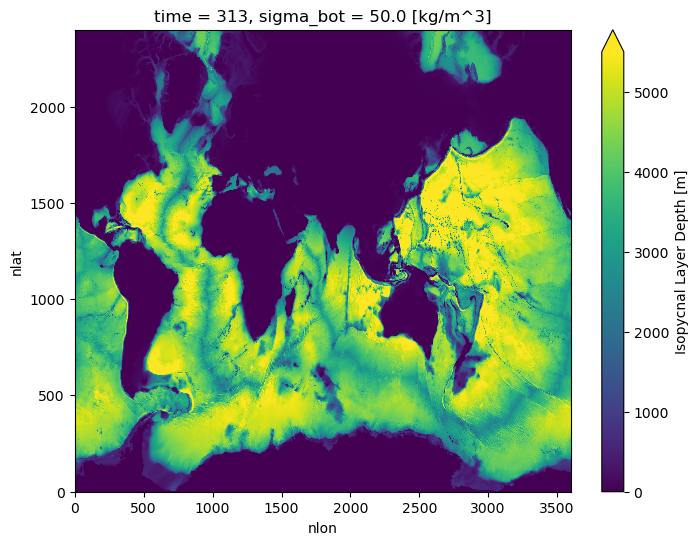

In [23]:
iso_depth.isel(time=0,sigma_bot=-1).plot(size=6,vmax=5500)

In [24]:
%%time
# Isopycnal depth of bottom-most layer should be same as HT.
htdiff =  iso_depth.isel(sigma_bot=-1) - (ds_grid['HT']/100.).assign_attrs({'units':'m'})
print("Max difference from true HT = {}m".format(abs(htdiff).max().values))

Max difference from true HT = 336.3848647680664m
CPU times: user 1min 28s, sys: 53.5 s, total: 2min 21s
Wall time: 36.4 s


In [25]:
htdiff = xr.where(htdiff.values==1.00000000e-02,np.nan,htdiff)
htdiff = xr.where(htdiff.values==0,np.nan,htdiff)

In [26]:
htdiff[0,:300,0].values

array([            nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,  

In [27]:
abs(htdiff[0,:300,:]).min().values

/home/lix/.conda/envs/POP_MOC/lib/python3.8/site-packages/dask/array/reductions.py:611: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)


array(3.90625132e-08)

### 6. Compute Isopycnal Layer Horizontal Volume Flux

In [28]:
## Grid Metrics
dxu = ds_grid['DXU']
dyu = ds_grid['DYU']
dxt = ds_grid['DXT']
dyt = ds_grid['DYT']

In [29]:
u_e = ds['UVEL']
u_e = u_e.where(u_e<1.e30,np.nan)
v_e = ds['VVEL']
v_e = v_e.where(v_e<1.e30,np.nan)

In [30]:
%%time
# Grid-oriented Volume FLuxes:
u_e = (u_e*dyu*dzu/1.e4).assign_attrs({'units':'m^3/s'})
v_e = (v_e*dxu*dzu/1.e4).assign_attrs({'units':'m^3/s'})

CPU times: user 15.2 s, sys: 1.23 s, total: 16.4 s
Wall time: 16 s


In [31]:
%%time
# Convert u_e,v_e to C-grid fluxes
u = 0.5*(u_e+u_e.shift(nlat=1))
v = 0.5*(v_e+v_e.roll(nlon=1,roll_coords=False))

CPU times: user 20.7 ms, sys: 332 µs, total: 21 ms
Wall time: 20.7 ms


In [32]:
%%time
# Volume fluxes in density-space. 
iso_uflux = histogram(sigma2_T, bins=[sigma_edge.values],weights=u,dim=['z_t'],density=False)
iso_uflux = iso_uflux.rename({'density_bin':'sigma'}).assign_coords({'sigma':sigma_mid})

iso_vflux = histogram(sigma2_T, bins=[sigma_edge.values],weights=v,dim=['z_t'],density=False)
iso_vflux = iso_vflux.rename({'density_bin':'sigma'}).assign_coords({'sigma':sigma_mid})

CPU times: user 17.9 ms, sys: 948 µs, total: 18.9 ms
Wall time: 18.5 ms


In [33]:
#%%time
#iso_uflux = iso_uflux.persist()
#daskout = wait(iso_uflux)

In [34]:
#%%time
#iso_vflux = iso_vflux.persist()
#daskout = wait(iso_vflux)

In [35]:
%%time
# Vertical sum in density-space should reproduce vertical sum in depth-space
ufluxdiff = iso_uflux.isel(time=0).sum('sigma') - u.isel(time=0).sum('z_t')
print("Max difference from true Uflux = {}".format(abs(ufluxdiff).max().values))
vfluxdiff = iso_vflux.isel(time=0).sum('sigma') - v.isel(time=0).sum('z_t')
print("Max difference from true Vflux = {}".format(abs(vfluxdiff).max().values))

Max difference from true Uflux = 30186.85552092707
Max difference from true Vflux = 41702.1333248703
CPU times: user 3min 28s, sys: 1min 46s, total: 5min 14s
Wall time: 1min 53s


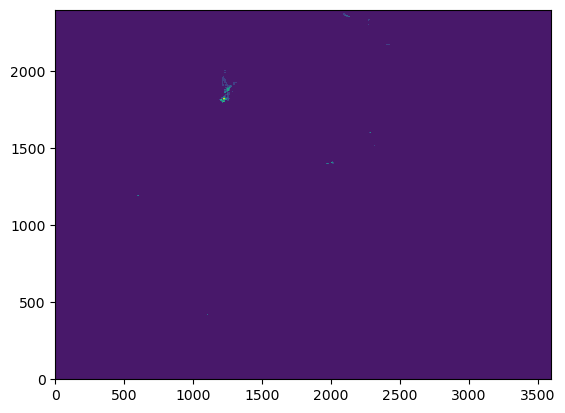

In [36]:
plt.contourf(abs(ufluxdiff[:,:]))

In [37]:
ufluxdiff[:500,0].values

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

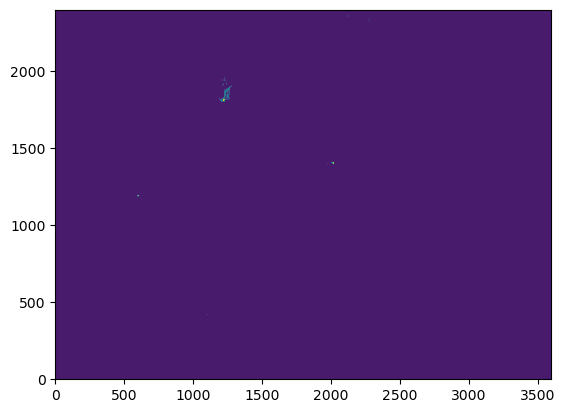

In [38]:
plt.contourf(abs(vfluxdiff[:,:]))

### 7. Compute Vertical Volume Flux from horizontal flux convergence

In [39]:
%%time
wflux = popmoc.wflux(iso_uflux,iso_vflux,'sigma',sigma_edge,grid='C')
wflux = wflux.assign_coords({'TLAT':ds['TLAT'],'TLONG':ds['TLONG']}).drop(['ULAT','ULONG'])

CPU times: user 26.3 ms, sys: 2.84 ms, total: 29.1 ms
Wall time: 28.9 ms


In [40]:
#%%time
#wflux = wflux.persist()
#daskout = wait(wflux)

### 8. Define MOC region masks

In [41]:
## Define the MOC region mask:
rmask = ds_grid.REGION_MASK.drop(['ULONG','ULAT'])
rmaskglob = xr.where((rmask>0),1,0)
rmaskatl = xr.where((rmask>=6) & (rmask<=11),1,0)
rmaskmoc = xr.concat([rmaskglob,rmaskatl],dim=ds_moctemp.transport_regions)

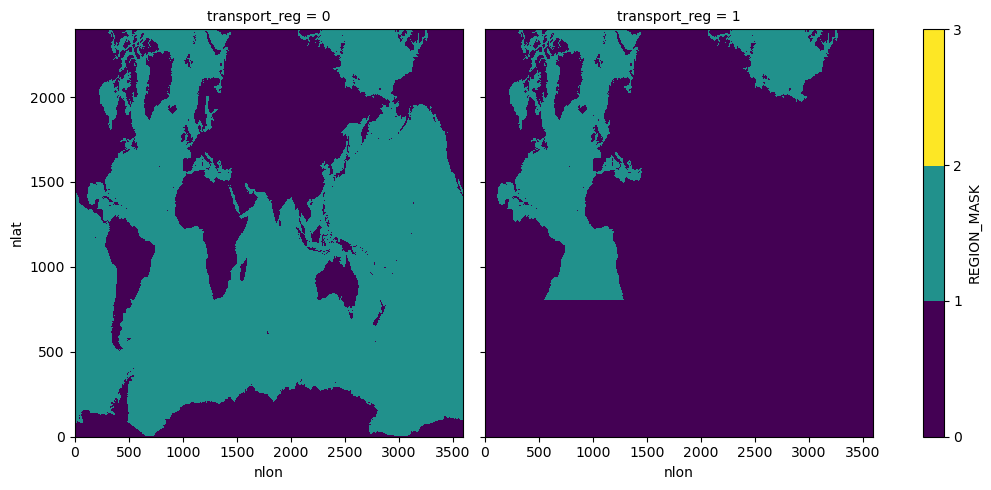

In [42]:
rmaskmoc.plot(levels=[0,1,2,3],col='transport_reg',size=5);

### 9. Compute MOC

In [43]:
%%time
MOC = popmoc.compute_MOC(wflux,rmaskmoc,ds_moctemp.lat_aux_grid)
MOC = MOC.transpose('time','transport_reg','sigma','lat_aux_grid')

CPU times: user 1.04 s, sys: 148 ms, total: 1.18 s
Wall time: 1.05 s


In [44]:
MOC

<xarray.DataArray 'MOC' (time: 1, transport_reg: 2, sigma: 86, lat_aux_grid: 394)>
dask.array<transpose, shape=(1, 2, 86, 394), dtype=float32, chunksize=(1, 2, 86, 394), chunktype=numpy.ndarray>
Coordinates:
  * lat_aux_grid       (lat_aux_grid) float32 -78.95 -78.42 ... 89.47 90.0
  * time               (time) int64 313
  * sigma              (sigma) float32 0.0 28.1 28.3 28.5 ... 37.88 37.93 37.97
    transport_regions  (transport_reg) |S256 ...
Dimensions without coordinates: transport_reg
Attributes:
    long_name:  Meridional Overturning Circulation
    units:      Sv

In [45]:
#%%time
#MOC = MOC.load()
#daskout = wait(MOC)

### 10. Add Southern Boundary Fluxes for Atlantic Region

In [46]:
# determine j=index of Atlantic region southern boundary
tmp = rmaskmoc.isel(transport_reg=1).sum('nlon')
atl_j = 0
j = 0
while (atl_j==0):
    if (tmp.isel(nlat=j).data>0):
        atl_j = j
    j += 1
atl_j = atl_j - 1
atl_j

809

In [47]:
%%time
# add vflux at southern boundary of Atlantic domain
tmp = iso_vflux*(rmaskmoc.shift(nlat=-1))
tmp = tmp.isel(nlat=atl_j,transport_reg=1).sum('nlon')
moc_s = -tmp.sortby('sigma',ascending=False).cumsum('sigma').sortby('sigma',ascending=True)/1.e6
moc_s['sigma'] = sigma_edge.isel(sigma=slice(0,-1))
MOC[{'transport_reg':1}] = MOC[{'transport_reg':1}] + moc_s

CPU times: user 418 ms, sys: 51.1 ms, total: 469 ms
Wall time: 468 ms


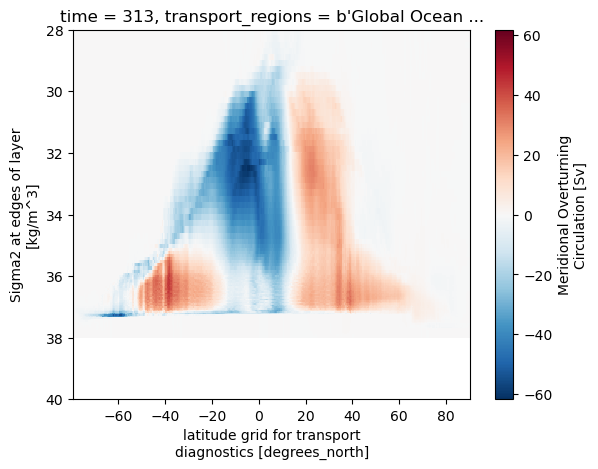

In [48]:
MOC.isel(time=0).isel(transport_reg=0).plot(ylim=[40,28])

In [49]:
MOC.transport_regions

<xarray.DataArray 'transport_regions' (transport_reg: 2)>
array([b'Global Ocean - Marginal Seas',
       b'Atlantic Ocean + Mediterranean Sea + Labrador Sea + GIN Sea + Arctic Ocean + Hudson Bay'],
      dtype='|S256')
Coordinates:
    transport_regions  (transport_reg) |S256 b'Global Ocean - Marginal Seas' ...
Dimensions without coordinates: transport_reg
Attributes:
    long_name:  regions for all transport diagnostics
    units:

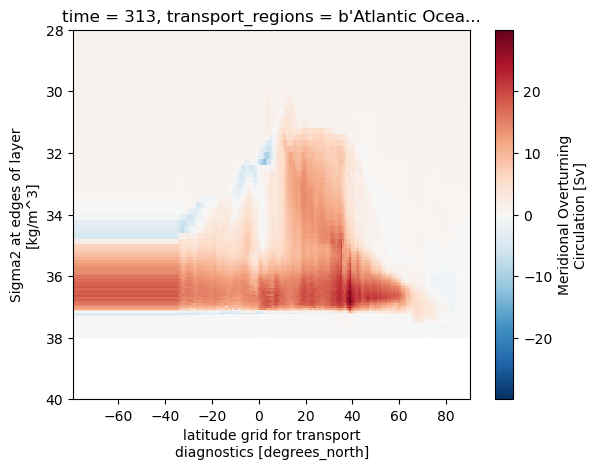

In [50]:
MOC.isel(time=0).isel(transport_reg=1).plot(ylim=[40,28])

### 11. Save to netcdf

In [51]:
#MOCann = MOC.groupby('time.year').mean('time').rename({'year':'time'})
#dsout = MOCann.to_dataset()
#dsout['iso_thick'] = iso_thick
#dsout['iso_depth'] = iso_depth

In [52]:
#fout = '/home/dxl/POP_MOC-main/POP_MOC-main/notebooks/pop.h.031309.MOCsig2.nc'
#dsout.to_netcdf(fout,unlimited_dims='time')

In [53]:
#######try
#MOCvalue = MOC.isel(time=0).isel(transport_reg=0)

In [54]:
#MOCvalue.shape

In [55]:
#np.nanmax(MOCvalue)

In [56]:
#MOC.isel(time=0).isel(transport_reg=0).plot(ylim=[40,28])